In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings("ignore")
headlines = pd.read_csv(
    "../data/india-news-headlines.csv", parse_dates=[0], infer_datetime_format=True
)
headlines.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [2]:
stop_words = set(stopwords.words('english'))

def build_corpus(data):
    corpus = []
    for sentence in data.iteritems():
        word_list = sentence[1].split(" ")
        word_list = [each_string.lower() for each_string in word_list]
        filtered_sentence = [w for w in word_list if not w in stop_words]
        corpus.append(filtered_sentence)
    return corpus

#corpus = build_corpus(headlines['headline_text'].astype(str))

In [3]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [4]:
#!pip install --upgrade gensim==3.8.3 --user
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn import cluster, metrics, mixture
from scipy.spatial.distance import cdist
from collections import Counter

In [5]:
year_month = '2020-04'
headlines["month_year"] = headlines["publish_date"].dt.to_period("M")
corpus = build_corpus(headlines.loc[headlines['month_year'] == year_month].headline_text)
model = Word2Vec(corpus, size=2500, min_count=1)

vectors = model[model.wv.vocab]
words = list(model.wv.vocab)
X = pd.concat([pd.DataFrame(words, columns=['word']), pd.DataFrame(vectors)], axis=1)

top100_frequencies = get_top_n_words(headlines.loc[headlines['month_year'] == year_month].headline_text, 100)
top100 = [i[0] for i in top100_frequencies]

kmeans = KMeans(n_clusters=8, random_state=0).fit(X.drop(['word'], axis=1))

X_ = pd.concat([X, pd.DataFrame(kmeans.labels_, columns=['label'], index=X.index)], axis=1)

X100 = X_[X_['word'].isin(top100)]

dct = {}
for label in X_.label.unique():
    dct[f'cluster_{label}'] = (X100['word'].loc[X100['label'] == label].tolist())
display(Counter(kmeans.labels_))
#display(dct)

Counter({7: 283, 4: 105, 6: 26, 0: 15873, 3: 658, 5: 2138, 1: 64, 2: 22})

In [6]:
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors

pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)
# prepare a dataframe
words = pd.DataFrame(words)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
clusters = pd.DataFrame(kmeans.labels_, columns=['label'], index=PCA_final.index)
PCA_data_complet = pd.concat([PCA_final[['word','x_values','y_values']], clusters], axis=1)
PCA_data_complet100 = PCA_data_complet[PCA_data_complet['word'].isin(top100)]

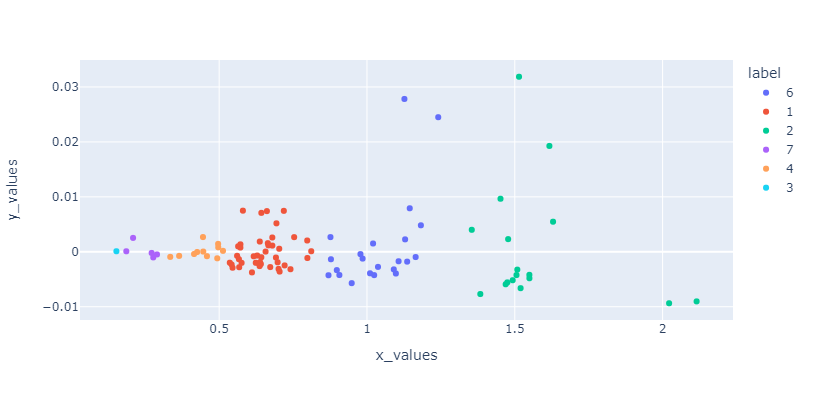

In [13]:
import plotly.express as px
PCA_data_complet100.label = PCA_data_complet100.label.astype(str)
fig = px.scatter(PCA_data_complet100, x="x_values", y="y_values", color='label', hover_name="word", width=500, height=400)
fig.show()